# Mosquito Segmentation Tutorial

This tutorial demonstrates how to use the CulicidaeLab library to perform mosquito segmentation on images. We'll cover:

1. Setting up the segmentation model
2. Loading and preprocessing images
3. Running segmentation
4. Visualizing results

First, let's import the necessary libraries:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from culicidaelab import MosquitoSegmenter
from culicidaelab.predictors.detector import MosquitoDetector
from culicidaelab.core.settings import Settings

c:\Users\lenova\CascadeProjects\culicidaelab\.venv\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_path" in PredictorConfig has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\lenova\CascadeProjects\culicidaelab\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initialize Settings and Segmenter

First, we'll initialize our settings and create a MosquitoSegmenter instance:

In [2]:
"""
Module for mosquito segmentation using SAM (Segment Anything Model).
"""

from __future__ import annotations

import cv2
import numpy as np
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pathlib import Path
from culicidaelab.core.base_predictor import BasePredictor
from culicidaelab.core.settings import get_settings
from culicidaelab.core.utils import str_to_bgr


class MosquitoSegmenter(BasePredictor):
    """Class for segmenting mosquitos in images using SAM."""

    def __init__(self, settings: Settings,
                load_model: bool = False,) -> None:
        """
        Initialize the mosquito segmenter.

        Args:
            model_path: Path to SAM model checkpoint
            config_manager: Configuration manager instance
        """
        super().__init__(settings=settings,
                         predictor_type="segmenter",
                         load_model=load_model)

    def _load_model(self) -> None:
        """Load the SAM model."""

        sam2_model = build_sam2(self.config.sam_config_path,
                                self.model_path,
                                device=self.config.device)
        self._model = SAM2ImagePredictor(sam2_model)

    def predict(
        self,
        input_data: np.ndarray,
        detection_boxes: list[tuple[float, float, float, float, float]] | None = None,
    ) -> np.ndarray:
        """
        Segment mosquitos in an image.

        Args:
            input_data: Input image as numpy array
            detection_boxes: Optional list of detection boxes (x, y, w, h, conf)

        Returns:
            np.ndarray: Binary mask of segmented mosquitos
        """
        if not self.model_loaded:
            self.load_model()

        if len(input_data.shape) == 2:
            input_data = cv2.cvtColor(input_data, cv2.COLOR_GRAY2RGB)
        elif input_data.shape[2] == 4:
            input_data = cv2.cvtColor(input_data, cv2.COLOR_RGBA2RGB)

        self._model.set_image(input_data)

        if detection_boxes:
            masks = []
            for box in detection_boxes:
                x, y, w, h, _ = box
                input_box = np.array([x, y, x + w, y + h])
                mask, _, _ = self._model.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                masks.append(mask)
            return np.logical_or.reduce(masks) if masks else np.zeros(input_data.shape[:2], dtype=bool)

        masks = self._model.generate()
        return (
            np.logical_or.reduce([m["segmentation"] for m in masks])
            if masks
            else np.zeros(input_data.shape[:2], dtype=bool)
        )

    def visualize(
        self,
        input_data: np.ndarray,
        predictions: np.ndarray,
        save_path: str | Path | None = None,
    ) -> np.ndarray:
        """
        Visualize segmentation mask on the image.

        Args:
            input_data: Original image
            predictions: Binary segmentation mask
            save_path: Optional path to save visualization

        Returns:
            np.ndarray: Image with overlay visualization
        """
        overlay = input_data.copy()
        overlay[predictions] = cv2.addWeighted(
            overlay[predictions],
            self.config.visualization["alpha"],
            np.array(str_to_bgr(self.config.visualization["overlay_color"])),
            1 - self.config.visualization["alpha"],
            0,
        )

        if save_path:
            cv2.imwrite(str(save_path), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

        return overlay

    def evaluate(
        self,
        input_data: np.ndarray,
        ground_truth: np.ndarray,
    ) -> dict[str, float]:
        """
        Evaluate segmentation predictions against ground truth mask.

        Args:
            input_data: Input image
            ground_truth: Ground truth binary mask

        Returns:
            Dictionary containing IoU and other metrics
        """
        predictions = self.predict(input_data)

        intersection = np.logical_and(predictions, ground_truth)
        union = np.logical_or(predictions, ground_truth)

        iou = float(np.sum(intersection)) / float(np.sum(union)) if np.sum(union) > 0 else 0.0
        precision = float(np.sum(intersection)) / float(np.sum(predictions)) if np.sum(predictions) > 0 else 0.0
        recall = float(np.sum(intersection)) / float(np.sum(ground_truth)) if np.sum(ground_truth) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        return {
            "iou": iou,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }


In [3]:
# Get settings instance
settings = get_settings()
settings.list_model_types()

['classifier', 'detector', 'segmenter']

In [4]:

"""
Model weights management module for CulicidaeLab.
"""

from __future__ import annotations
import shutil
from pathlib import Path

from huggingface_hub import hf_hub_download

from culicidaelab.core.settings import Settings


class ModelWeightsManager:
    """Manages ensuring model weights are available locally, downloading if necessary."""

    def __init__(self, settings: Settings):
        """Initialize the model weights manager."""
        self.settings = settings

    def ensure_weights(self, model_type: str) -> Path:
        """
        Ensures weights for a model type exist locally, downloading if not.
        This method correctly handles and resolves symbolic links.

        Args:
            model_type: The key for the predictor (e.g., 'classifier').

        Returns:
            The absolute, canonical Path to the validated, existing model file.
        """
        local_path = self.settings.get_model_weights(model_type).resolve()

        if local_path.exists():
            if local_path.is_symlink():
                try:
                    real_path = local_path.resolve(strict=True)
                    print(f"Symlink found at {local_path}, resolved to real file: {real_path}")
                    return real_path
                except FileNotFoundError:
                    print(f"Warning: Broken symlink found at {local_path}. It will be removed.")
                    local_path.unlink()
            else:
                print(f"Weights file found at: {local_path}")
                return local_path

        # If we get here, the path either does not exist or was a broken symlink.
        # We must now download the file.
        print(f"Model weights for '{model_type}' not found. Attempting to download...")

        predictor_config = self.settings.get_config(f'predictors.{model_type}')
        repo_id = predictor_config.repository_id
        filename = predictor_config.filename

        if not repo_id or not filename:
            raise ValueError(
                f"Cannot download weights for '{model_type}'. "
                f"Configuration is missing 'repository_id' or 'filename'. "
                f"Please place the file manually at: {local_path}"
            )

        try:
            dest_dir = local_path.parent.resolve()
            print(f"Ensuring destination directory exists: {dest_dir}")

            # Robust directory creation with validation
            dest_dir.mkdir(parents=True, exist_ok=True)
            if not dest_dir.is_dir():
                raise NotADirectoryError(f"Failed to create directory: {dest_dir}")

            # Download the file to the Hugging Face cache
            downloaded_path_str = hf_hub_download(
                repo_id=repo_id,
                filename=filename,
                cache_dir=self.settings.cache_dir / "huggingface",
                local_dir=str(local_path.parent),
                )
            print(f"Downloaded weights to: {downloaded_path_str}")
            if model_type == "segmenter":
                # For segmenter, we need to ensure the file is not a symlink
                downloaded_yaml = hf_hub_download(
                repo_id=repo_id,
                filename=predictor_config.sam_config_filename,
                cache_dir=self.settings.cache_dir / "huggingface",
                local_dir=str(local_path.parent),
                )
                print(f"Downloaded SAM config to: {downloaded_yaml}")
            # # Now we can safely copy the file.
            # print(f"Copying weights to: {local_path}")
            # shutil.copy(downloaded_path_str, str(local_path))

            print(f"Successfully downloaded weights to: {local_path}")
            return local_path
        except Exception as e:
            # Clean up a potentially partial file on failure
            if local_path.exists():
                local_path.unlink()
            # Include directory info in error message
            dir_status = "exists" if dest_dir.exists() else "missing"
            dir_type = "directory" if dest_dir.is_dir() else "not-a-directory"
            raise RuntimeError(
                f"Failed to download weights for '{model_type}' to {local_path}. "
                f"Directory status: {dir_status} ({dir_type}). Error: {e}"
            ) from e


In [7]:
ModelWeightsManager(settings).ensure_weights("segmenter")

Model weights for 'segmenter' not found. Attempting to download...
Ensuring destination directory exists: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\segmentation
Downloaded weights to: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\segmentation\sam2.1_hiera_tiny.pt
Downloaded SAM config to: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\segmentation\sam2.1_hiera_t.yaml
Successfully downloaded weights to: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\segmentation\sam2.1_hiera_tiny.pt


Path('C:/Users/lenova/AppData/Local/culicidaelab/culicidaelab/models/weights/segmentation/sam2.1_hiera_tiny.pt')

In [70]:
"""
Module for mosquito segmentation using SAM (Segment Anything Model).
"""

from __future__ import annotations

import cv2
import numpy as np
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pathlib import Path
from culicidaelab.core.base_predictor import BasePredictor
from culicidaelab.core.settings import Settings
from culicidaelab.core.utils import str_to_bgr


class MosquitoSegmenter(BasePredictor):
    """Class for segmenting mosquitos in images using SAM."""

    def __init__(self, settings: Settings,
                load_model: bool = False) -> None:
        """
        Initialize the mosquito segmenter.

        Args:
            model_path: Path to SAM model checkpoint
            config_manager: Configuration manager instance
        """
        super().__init__(settings=settings,
                         predictor_type="segmenter",
                         load_model=load_model)

    def _load_model(self) -> None:
        """Load the SAM model."""
        sam_config_path = str(settings.model_dir / self.config.sam_config_path)
        sam2_model = build_sam2(sam_config_path,
                                self.model_path,
                                device=self.config.device)
        self._model = SAM2ImagePredictor(sam2_model)

    def predict(
        self,
        input_data: np.ndarray,
        detection_boxes: list[tuple[float, float, float, float, float]] | None = None,
    ) -> np.ndarray:
        """
        Segment mosquitos in an image.

        Args:
            input_data: Input image as numpy array
            detection_boxes: Optional list of detection boxes (x, y, w, h, conf)

        Returns:
            np.ndarray: Binary mask of segmented mosquitos
        """
        if not self.model_loaded:
            self.load_model()

        if len(input_data.shape) == 2:
            input_data = cv2.cvtColor(input_data, cv2.COLOR_GRAY2RGB)
        elif input_data.shape[2] == 4:
            input_data = cv2.cvtColor(input_data, cv2.COLOR_RGBA2RGB)

        self._model.set_image(input_data)

        if detection_boxes:
            masks = []
            for box in detection_boxes:
                x, y, w, h, _ = box
                x1 = int(x - w / 2)
                y1 = int(y - h / 2)
                x2 = int(x + w / 2)
                y2 = int(y + h / 2)
                input_box = np.array([x1, y1, x2, y2])

                mask, _, _ = self._model.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                masks.append(mask[0].astype(np.uint8))
            return np.logical_or.reduce(masks) if masks else np.zeros(input_data.shape[:2], dtype=bool)

        masks, scores, _ = self._model.predict(
                    point_coords=None,
                    point_labels=None,
                    box=None,
                    multimask_output=False,
                )

        return masks[0].astype(np.uint8)

    def visualize(
        self,
        input_data: np.ndarray,
        predictions: np.ndarray,
        save_path: str | Path | None = None,
    ) -> np.ndarray:
        """
        Visualize segmentation mask on the image.

        Args:
            input_data: Original image
            predictions: Binary segmentation mask
            save_path: Optional path to save visualization

        Returns:
            np.ndarray: Image with overlay visualization
        """
        if len(input_data.shape) == 2:
            input_data = cv2.cvtColor(input_data, cv2.COLOR_GRAY2BGR)

        colored_mask = np.zeros_like(input_data)
        colored_mask[predictions > 0] = np.array(str_to_bgr(self.config.visualization["overlay_color"]))

        overlay = cv2.addWeighted(input_data,
                                  1,
                                  colored_mask,
                                  self.config.visualization["alpha"],
                                  0)

        if save_path:
            cv2.imwrite(str(save_path), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

        return overlay

    def evaluate(
        self,
        input_data: np.ndarray,
        ground_truth: np.ndarray,
    ) -> dict[str, float]:
        """
        Evaluate segmentation predictions against ground truth mask.

        Args:
            input_data: Input image
            ground_truth: Ground truth binary mask

        Returns:
            Dictionary containing IoU and other metrics
        """
        predictions = self.predict(input_data)

        intersection = np.logical_and(predictions, ground_truth)
        union = np.logical_or(predictions, ground_truth)

        iou = float(np.sum(intersection)) / float(np.sum(union)) if np.sum(union) > 0 else 0.0
        precision = float(np.sum(intersection)) / float(np.sum(predictions)) if np.sum(predictions) > 0 else 0.0
        recall = float(np.sum(intersection)) / float(np.sum(ground_truth)) if np.sum(ground_truth) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        return {
            "iou": iou,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }


In [71]:
model_config = settings.get_config("predictors.segmenter")
model_path = settings.get_model_weights("segmenter")

# Initialize segmenter
segmenter = MosquitoSegmenter(settings=settings, load_model=True)

Weights file found at: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\segmentation\sam2.1_hiera_tiny.pt


## 2. Load and Preprocess Image

Now let's load a test image:

In [72]:
# Load test image
image_path = str(Path("test_img") / "640px-Aedes_aegypti.jpg")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## 3. Run Segmentation

Now we can run the segmentation model on our image:

In [73]:
mask = segmenter.predict(image)

## 4. Visualize Results

Finally, let's visualize the segmentation results overlaid on the original image:

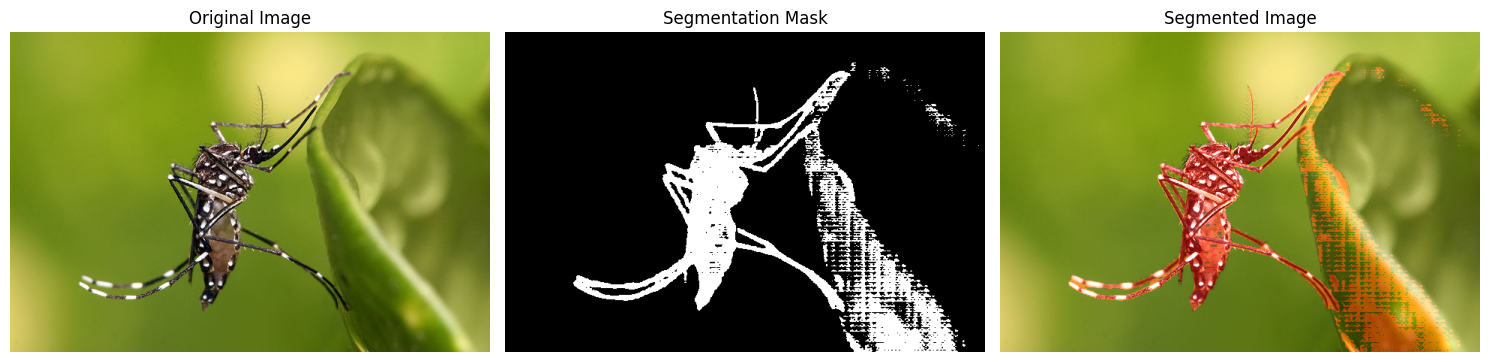

In [74]:
# Visualize segmentation results
segmented_image = segmenter.visualize(image, mask)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.title("Segmentation Mask")

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.axis("off")
plt.title("Segmented Image")

plt.tight_layout()
plt.show()

## Segmentation Using Detection Results

The segmenter can also use detection results to improve segmentation accuracy. Here's how to combine detection and segmentation:

Weights file found at: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\detection\culico-net-det-v1-nano.pt
C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\detection\culico-net-det-v1-nano.pt
cpu

0: 448x640 1 aegypti, 274.5ms
Speed: 4.5ms preprocess, 274.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

Detection Results:
Mosquito 1: Confidence = 0.83, Box = (x=299.6, y=227.9, w=359.2, h=365.3)


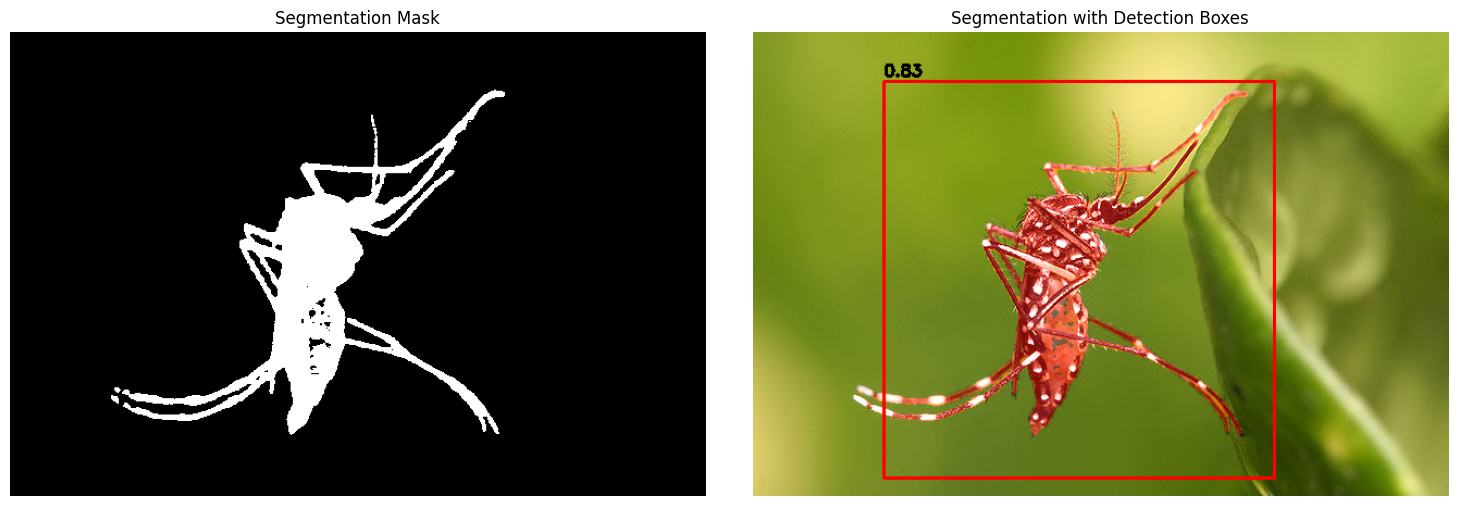

In [75]:
from culicidaelab import MosquitoDetector

# Initialize detector
detector = MosquitoDetector(
        settings=settings,
        load_model=True
        )
# Load test image
image_path = str(Path("test_img") / "640px-Aedes_aegypti.jpg")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run detection
detections = detector.predict(image)

# Run segmentation with detection boxes
mask_with_boxes = segmenter.predict(image, detection_boxes=detections)
# Draw detections
annotated_image = detector.visualize(image, detections)

# Print detection results
print("\nDetection Results:")
for i, (x, y, w, h, conf) in enumerate(detections):
    print(f"Mosquito {i+1}: Confidence = {conf:.2f}, Box = (x={x:.1f}, y={y:.1f}, w={w:.1f}, h={h:.1f})")
# Visualize results
segmented_image_with_boxes = segmenter.visualize(annotated_image, mask_with_boxes)

# plt.figure(figsize=(10, 10))
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask_with_boxes, cmap="gray")
plt.axis("off")
plt.title("Segmentation Mask")


plt.subplot(1, 2, 2)
plt.imshow(segmented_image_with_boxes)
plt.axis("off")
plt.title("Segmentation with Detection Boxes")

plt.tight_layout()
plt.show()